In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
#Create X and Y arrays
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Initialize the final arrays correctly
X_final_array = np.empty((0, 3072))  # CIFAR-10 has 3072 features (32x32x3)
Y_final_array = np.empty((0,))  # Correct initialization for Y

for i in range(1, 6):
    # The path to the data
    url = '/Users/josemiguelvilchesfierro/Downloads/cifar-10-batches-py/data_batch_'+str(i)

    # Load the data
    unpickle_data = unpickle(url)
    
    # This is the 'data' which is in uint8 format
    X_temp = unpickle_data[b'data']
    Y_temp = np.array(unpickle_data[b'labels'])  # Convert Y_temp to a NumPy array
    
    # Concatenate temp_array to final_array along axis 0
    X_final_array = np.concatenate((X_final_array, X_temp), axis=0)
    Y_final_array = np.concatenate((Y_final_array, Y_temp), axis=0)

# Convert to tensors
X = torch.tensor(X_final_array)
X = X.view(-1, 3, 32, 32)  # Reshape to (batch_size, channels, height, width)
Y = torch.tensor(Y_final_array)

print(X.shape, Y.shape)

torch.Size([50000, 3, 32, 32]) torch.Size([50000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [5.0..254.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [20.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [4.0..234.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..254.0].


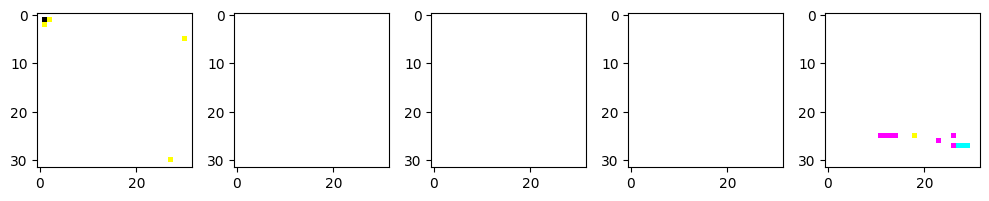

In [3]:
#Showing pictures

# Create a figure with subplots to display multiple images
plt.figure(figsize=(10, 5))  # Adjust the size as needed

# Loop to display 10 images
for i in range(5):
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots
    img = X[i].reshape(3, 32, 32).permute(1, 2, 0)  # Reshape and permute the image tensor
    plt.imshow(img.detach().numpy())  # Convert to NumPy and display

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show all images

In [4]:
import torch
import torch.nn.functional as F

class linear:
    def __init__(self, input_size, output_size):
        self.weights = torch.randn(input_size, output_size, dtype=torch.float32) * 0.3
        self.biases = torch.zeros(output_size, dtype=torch.float32) * 0.3

    def forward(self, input):
        self.input = input.float()
        self.output = torch.mm(self.input, self.weights) + self.biases
        return self.output

    def __call__(self, X):
        return self.forward(X)
    
    def parameters(self):
        return [self.weights] if self.biases is None else [self.weights, self.biases]

#----------------------------------------------------------------------
class convolutional:
    def __init__(self, input_depth, kernel_size, n_kernels):
        self.input_depth = input_depth
        self.kernel_size = kernel_size
        self.n_kernels = n_kernels
        self.kernels = torch.randn(n_kernels, input_depth, kernel_size, kernel_size, dtype=torch.float32) * 0.3
        self.biases = torch.zeros(n_kernels, dtype=torch.float32) * 0.3

    def forward(self, input):
        self.input = input.float()
        self.output = F.conv2d(self.input, self.kernels, self.biases)
        return self.output

    
    def __call__(self,X):
        return self.forward(X)
    
    def parameters(self):
        return [self.kernels, self.biases]
#----------------------------------------------------------------------
class sequential:
    def __init__(self, layers):
        self.layers = layers      

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        self.out = [p for layer in self.layers for p in layer.parameters()]
        return self.out

#----------------------------------------------------------------------
class tanh:
    def __call__(self, x):
        return torch.tanh(x)
    
    def parameters(self):
        return []

#----------------------------------------------------------------------

class reshape():
    def __init__(self, output_shape):
        self.output_shape = output_shape

    def __call__(self, X):
        return self.forward(X)

    def forward(self, input):
        #print(f"Reshape Input shape : {input.shape}")
        batch_size = input.shape[0]
        self.output = input.view(batch_size, -1)  # Flatten the input dynamically
        #print(f"Reshape Output shape : {self.output.shape}")
        return self.output
    
    def parameters(self):
        return []


In [5]:
# Define your kernel size and number of kernels
kernel_size = 3
n_kernels = 2

# Build the model
model = sequential([
    convolutional(3, kernel_size, n_kernels), tanh(),  # First conv layer
    convolutional(n_kernels, kernel_size, n_kernels), tanh(),  # Second conv layer
    convolutional(n_kernels, kernel_size, n_kernels), tanh(),  # Third conv layer
    reshape([n_kernels * 26 * 26]),  # Reshape to a flat vector
    tanh(),
    linear(n_kernels * 26 * 26, 10),  # Match the size expected
    tanh()
])

#Set parameters to train
parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

13662


In [9]:
max_steps = 100
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (batch_size,))
    Xb, Yb = X[ix], Y[ix] # batch X,Y

    optimizer = torch.optim.SGD(parameters, lr=0.01)
    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb.long())
    print(loss)
    optimizer.zero_grad()  # Reset gradients
    loss.backward()  # Backward pass
    optimizer.step()  # Update parameters     

tensor(2.6586, grad_fn=<NllLossBackward0>)
tensor(2.4307, grad_fn=<NllLossBackward0>)
tensor(2.9625, grad_fn=<NllLossBackward0>)
tensor(2.6248, grad_fn=<NllLossBackward0>)
tensor(3.0779, grad_fn=<NllLossBackward0>)
tensor(2.5757, grad_fn=<NllLossBackward0>)
tensor(2.5127, grad_fn=<NllLossBackward0>)
tensor(2.3135, grad_fn=<NllLossBackward0>)
tensor(2.2911, grad_fn=<NllLossBackward0>)
tensor(2.5603, grad_fn=<NllLossBackward0>)
tensor(2.3800, grad_fn=<NllLossBackward0>)
tensor(2.7159, grad_fn=<NllLossBackward0>)
tensor(2.7730, grad_fn=<NllLossBackward0>)
tensor(2.7214, grad_fn=<NllLossBackward0>)
tensor(2.4494, grad_fn=<NllLossBackward0>)
tensor(2.5369, grad_fn=<NllLossBackward0>)
tensor(2.6443, grad_fn=<NllLossBackward0>)
tensor(2.4167, grad_fn=<NllLossBackward0>)
tensor(2.6836, grad_fn=<NllLossBackward0>)
tensor(2.6803, grad_fn=<NllLossBackward0>)
tensor(2.3820, grad_fn=<NllLossBackward0>)
tensor(2.7992, grad_fn=<NllLossBackward0>)
tensor(2.7171, grad_fn=<NllLossBackward0>)
tensor(2.50